In [86]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [87]:
train_data=pl.read_csv("train_featureEngineered.csv").pipe(reduce_memory_usage)
test_data=pl.read_csv("test_featureEngineered.csv").pipe(reduce_memory_usage)
train_data.head()

customerID,SeniorCitizen,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,MonthlyCharges,TotalCharges,Churn,Streamer,Safer,Family,OnlinePayment,All,MonthlyChargesBin
str,i8,i8,i8,i8,i8,i8,i8,i8,i8,f32,f32,i8,i8,i8,i8,i8,i8,i8
"""7876-AEHIG""",0,51,0,1,1,0,1,1,12,60.150002,3077.0,0,1,1,0,0,0,0
"""8752-IMQOS""",0,5,0,2,0,0,0,0,12,20.1,85.099998,0,0,0,1,0,0,0
"""0256-LTHVJ""",0,28,0,0,0,0,0,0,1,81.050003,2227.100098,1,1,0,1,1,0,1
"""1981-INRFU""",0,2,0,0,0,0,0,0,1,79.75,164.5,1,1,0,0,1,0,1
"""0730-KOAVE""",0,30,1,0,1,1,0,0,1,94.300003,2679.699951,0,1,1,0,0,0,1


In [88]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2648369274639102

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("transformer", transformer),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10},random_state=42)),
    ]
)
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment', 'All',
                                                   'MonthlyChargesBin'])])),
                ('classifier',
                 LogisticRegression(class_weight={0: 1, 1: 2.648369274639102},
                                    random_state=42))])

Mean Train roc auc Score: 0.843703075314707
Mean Train recall Score: 0.7879839745632244

Mean Test roc auc Score: 0.841139018200249
Mean Test recall Score: 0.7838558860874297
Recall score: 0.80
Correlation : 0.48269555091504024
Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1031
           1       0.52      0.80      0.63       375

    accuracy                           0.75      1406
   macro avg       0.72      0.77      0.72      1406
weighted avg       0.81      0.75      0.77      1406



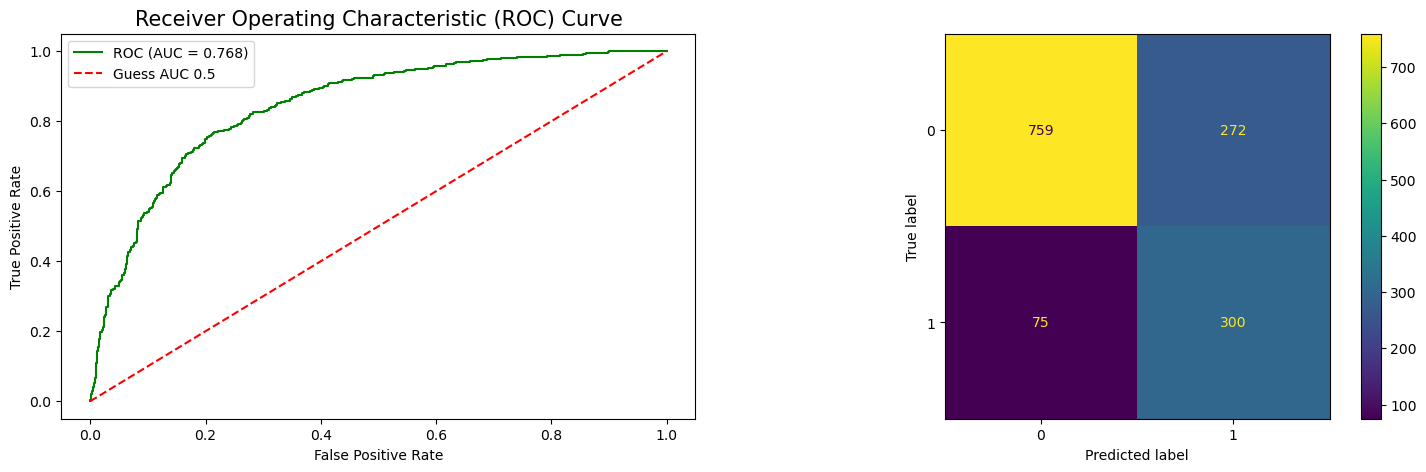

In [90]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,recall_score,matthews_corrcoef
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)
pipe.fit(X_train, y_train)

# Evaluation

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')
from sklearn.metrics import classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

In [91]:
from imblearn.over_sampling import SMOTEN
sm=SMOTEN(random_state=42,k_neighbors=3,n_jobs=-1)
X_train_smote,y_train_smote=sm.fit_resample(X_train,y_train)
X_test_smote,y_test_smote=sm.fit_resample(X_test,y_test)

In [92]:
balanced_train=pl.from_pandas(X_train_smote).hstack(pl.DataFrame(y_train_smote.to_numpy(),schema=["Churn"]))
balanced_test=pl.from_pandas(X_test_smote).hstack(pl.DataFrame(y_test_smote.to_numpy(),schema=["Churn"]))
balanced_train.write_csv("../Day5_Error_Analysis/balanced_train.csv")
balanced_test.write_csv("../Day5_Error_Analysis/balanced_test.csv")
balanced_train.write_csv("../Day6_Ensemble/balanced_train.csv")
balanced_test.write_csv("../Day6_Ensemble/balanced_test.csv")

Mean Train roc auc Score: 0.8768604003673095
Mean Train recall Score: 0.8042828282828283

Mean Test roc auc Score: 0.8749434416896236
Mean Test recall Score: 0.8048484848484849
Recall score: 0.83
Correlation : 0.6345221671662377
Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.81      0.81      1031
           1       0.81      0.83      0.82      1031

    accuracy                           0.82      2062
   macro avg       0.82      0.82      0.82      2062
weighted avg       0.82      0.82      0.82      2062



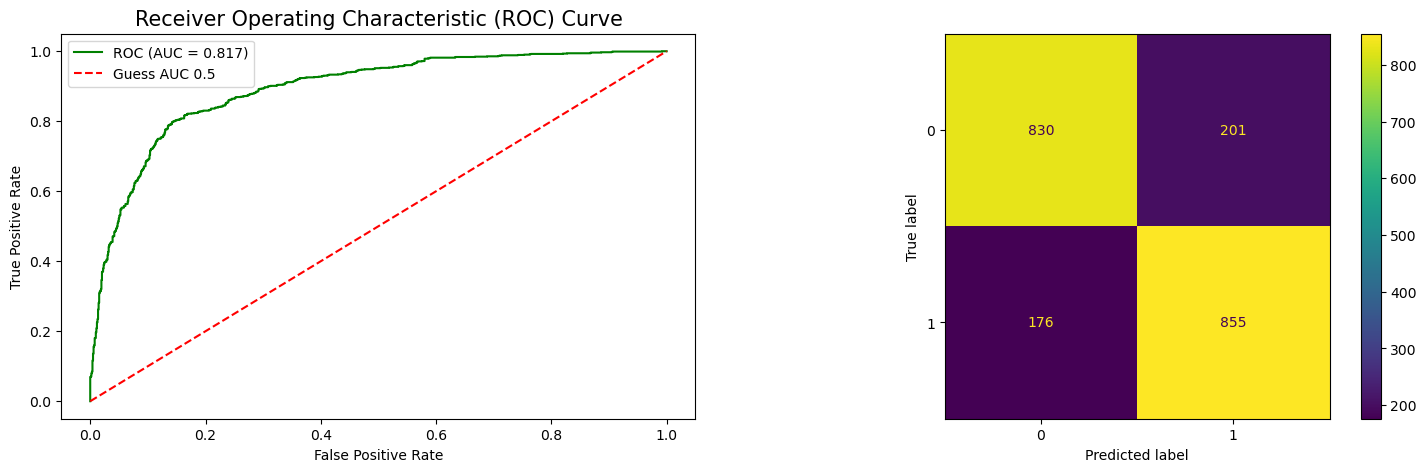

In [93]:
from sklearn.model_selection import cross_val_predict,RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score,recall_score,matthews_corrcoef
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
rskf= RepeatedStratifiedKFold(n_repeats=3,n_splits=3,random_state=42)
param_distributions = {
    'classifier__C': Real(1e-6, 1e+3, prior='log-uniform'),
    'classifier__max_iter': Integer(100, 1000),
    'classifier__penalty': Categorical(['l1', 'l2']),
    'classifier__fit_intercept': Categorical([True, False]),
    'classifier__solver': Categorical(['liblinear', 'saga'])
}

pipe_smote = Pipeline(
    [
        ("transformer", transformer),
        ("classifier", LogisticRegression(random_state=42)),
    ]
)

search = BayesSearchCV(
    estimator=pipe_smote,cv=rskf,
    search_spaces=param_distributions,
    n_iter=70,random_state=42,scoring='roc_auc')  

search.fit(X_train_smote, y_train_smote)
best_params = search.best_params_


pipe_smote.set_params(**best_params)
pipe_smote.fit(X_train_smote, y_train_smote)
# Evaluation

cv_results = cross_validate(pipe_smote, X_train_smote,y_train_smote, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)

cv_results = cross_validate(pipe_smote, X_train_smote,y_train_smote, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(pipe_smote,X_test_smote,y_test_smote,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test_smote, predictions)
recall = recall_score(y_test_smote,predictions)
coef = matthews_corrcoef(y_test_smote,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test_smote,predictions))
fpr, tpr, thresholds=roc_curve(y_test_smote,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test_smote,predictions,roc_auc)

In [94]:
pipe_smote

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment', 'All',
                                                   'MonthlyChargesBin'])])),
                ('classifier',
                 LogisticRegression(C=94.06655677792439, random_state=42,
                                    solver='liblinear'))])

In [95]:
import joblib

joblib.dump(pipe_smote, '../Day5_Error_Analysis/pipe_smote.joblib')
joblib.dump(pipe_smote, '../Day6_Ensemble/pipe_smote.joblib')

['../Day6_Ensemble/pipe_smote.joblib']

In [96]:
# from sklearn.model_selection import cross_val_predict, RepeatedStratifiedKFold
# from sklearn.metrics import roc_auc_score, f1_score, precision_score, accuracy_score, recall_score, matthews_corrcoef, classification_report
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from xgboost import XGBClassifier
# from sklearn.pipeline import Pipeline

# rskf = RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=42)

# param_distributions = {
#     'classifier__n_estimators': Integer(100, 1000),
#     'classifier__max_depth': Integer(3, 10),
#     'classifier__learning_rate': Real(1e-6, 1e-1, prior='log-uniform'),
#     'classifier__subsample': Real(0.6, 1.0),
#     'classifier__colsample_bytree': Real(0.6, 1.0),
#     'classifier__gamma': Real(0, 5),
#     'classifier__reg_alpha': Real(0, 5),
#     'classifier__reg_lambda': Real(0, 5),
#     'classifier__scale_pos_weight': Real(1, 10)
# }

# pipe_smote = Pipeline(
#     [
#         ("transformer", transformer),
#         ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
#     ]
# )

# search = BayesSearchCV(
#     estimator=pipe_smote,
#     search_spaces=param_distributions,
#     n_iter=20,
#     cv=rskf,
#     n_jobs=-1,
#     random_state=42
# )

# search.fit(X_train_smote, y_train_smote)
# best_params = search.best_params_

# pipe_smote.set_params(**best_params)
# pipe_smote.fit(X_train_smote, y_train_smote)

# pipe_smote.fit(X_train_smote, y_train_smote)
# # Evaluation
# predictions= cross_val_predict(pipe_smote,X_test_smote,y_test_smote,method='predict_proba',n_jobs=-1)
# predictions=[0 if x < 0.5 else 1 for x in predictions[:,1]]
# roc_auc = roc_auc_score(y_test_smote, predictions)
# f1 = f1_score(y_test_smote, predictions)
# accuracy = accuracy_score(y_test_smote, predictions)
# recall = recall_score(y_test_smote,predictions)
# precision = precision_score(y_test_smote,predictions)
# coef = matthews_corrcoef(y_test_smote,predictions)
# print(f"Area Under the Curve: {roc_auc:.2f}")
# print(f"F1 Score: {f1:.2f}")
# print(f"\033[1mRecall score: {recall:.2f}\033[0m")
# print(f"precision : {precision:.2f}")
# print(f"Xg boost Accuracy: {accuracy:.2f}")
# print(f"Corr : {coef}")
# print(classification_report(y_test_smote,predictions))